<a href="https://colab.research.google.com/github/ankurk017/Hurricane_Harvey/blob/master/March21_super_resolution_sub_pixel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Super-Resolution using an Efficient Sub-Pixel CNN

**Author:** [Xingyu Long](https://github.com/xingyu-long)<br>
**Date created:** 2020/07/28<br>
**Last modified:** 2020/08/27 <br>
**Description:** Implementing Super-Resolution using Efficient sub-pixel model on BSDS500.

## Introduction

ESPCN (Efficient Sub-Pixel CNN), proposed by [Shi, 2016](https://arxiv.org/abs/1609.05158)
is a model that reconstructs a high-resolution version of an image given a low-resolution version.
It leverages efficient "sub-pixel convolution" layers, which learns an array of
image upscaling filters.

In this code example, we will implement the model from the paper and train it on a small dataset,
[BSDS500](https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/resources.html).

In [1]:
passcode = 'Jelly0311'

## Setup

In [2]:
! pip install pydap
! pip install cartopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import tensorflow as tf

import os
import math
import numpy as np
import cartopy.crs as ccrs
from pydap.client import open_url
from pydap.cas.urs import setup_session


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory

from IPython.display import display

## Load data: BSDS500 dataset

### Download dataset

We use the built-in `keras.utils.get_file` utility to retrieve the dataset.

We create training and validation datasets via `image_dataset_from_directory`.

We rescale the images to take values in the range [0, 1].

In [4]:

def scaling(input_image):
    input_image = input_image / 255.0
    return input_image


# Scale from (0, 255) to (0, 1)
# train_ds = train_ds.map(scaling)
# valid_ds = valid_ds.map(scaling)

## Crop and resize images

Let's process image data.
First, we convert our images from the RGB color space to the
[YUV colour space](https://en.wikipedia.org/wiki/YUV).

For the input data (low-resolution images),
we crop the image, retrieve the `y` channel (luninance),
and resize it with the `area` method (use `BICUBIC` if you use PIL).
We only consider the luminance channel
in the YUV color space because humans are more sensitive to
luminance change.

For the target data (high-resolution images), we just crop the image
and retrieve the `y` channel.

In [5]:

# Use TF Ops to process.
def process_input(input, input_size, upscale_factor):

    return tf.image.resize(input, [input_size, input_size], method="area")


def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return input




Let's take a look at the input and target data.

## Build a model

Compared to the paper, we add one more layer and we use the `relu` activation function
instead of `tanh`.
It achieves better performance even though we train the model for fewer epochs.

In [6]:

def get_model(upscale_factor=3, channels=3):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inputs = keras.Input(shape=(None, None, channels))
    x = layers.Conv2D(64, 5, **conv_args)(inputs)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)

    return keras.Model(inputs, outputs)


## Define utility functions

We need to define several utility functions to monitor our results:

- `plot_results` to plot an save an image.
- `get_lowres_image` to convert an image to its low-resolution version.
- `upscale_image` to turn a low-resolution image to
a high-resolution version reconstructed by the model.
In this function, we use the `y` channel from the YUV color space
as input to the model and then combine the output with the
other channels to obtain an RGB image.

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL


def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )


def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y = img_to_array(ycbcr)

 #   y = y.astype("float32") / 255.0
    input = np.expand_dims(y, axis=0)

    print('A========================+A')
    out = model.predict(input)
    print('B========================+B')
    out_img_y = out

    return out_img_y


## Define callbacks to monitor training

The `ESPCNCallback` object will compute and display
the [PSNR](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio) metric.
This is the main metric we use to evaluate super-resolution performance.

In [8]:

class ESPCNCallback(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
      #  self.test_img = get_lowres_image(load_img(test_img_paths[0]), upscale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
      #  if epoch % 20 == 0:
      #      prediction = upscale_image(self.model, self.test_img)
          #  plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))


Define `ModelCheckpoint` and `EarlyStopping` callbacks.

In [9]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "/tmp/checkpoint"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model = get_model(channels=3)
model.summary()

callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 64)    4864      
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    36928     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 32)    18464     
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 27)    7803      
                                                                 
 tf.nn.depth_to_space (TFOpL  (None, None, None, 3)    0         
 ambda)                                                          
                                                             

In [10]:
model.predict(np.random.random((100, 20, 20, 3))).shape

4/4 [==============================] - 2s 32ms/step


(100, 60, 60, 3)

LOAD ACTUAL MERRA DATA

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import xarray as xr
import glob

In [53]:
files = glob.glob('/content/drive/MyDrive/MERRA_HURR/*nc')
get_data = lambda A: np.stack((A['U10M'].values, A['V10M'].values, A['U'].sel(lev=500).values, A['U'].sel(lev=850).values, A['U'].sel(lev=950).values, A['V'].sel(lev=500).values, A['V'].sel(lev=850).values, A['V'].sel(lev=950).values), axis=2)

In [14]:
len(files)

118

## Train the model

In [15]:

# Use TF Ops to process.
def process_input(input, input_size, upscale_factor):

    return tf.image.resize(input, [input_size, input_size], method="area")


def process_target(input):
   # input = tf.image.rgb_to_yuv(input)
    return input




In [16]:
data_train1 = (data_train[:,:,:,1] - np.nanmean(data_train[:,:,:,1].ravel()))/np.nanstd(data_train[:,:,:,1].ravel())


NameError: ignored

In [54]:
import tensorflow as tf
import numpy as np

# Set the number of samples and dimensions
num_traning_samples = 30
num_valid_samples = 5
num_channels = 9

num_dims = 99
upscale_factor = 3

input_size = num_dims // upscale_factor

epochs = 50

# Generate random data
# data_train = np.random.rand(num_traning_samples, num_dims, num_dims, num_channels)
# data_valid = np.random.rand(num_valid_samples, num_dims, num_dims, num_channels)

data_train = np.stack([get_data(xr.open_dataset(merra)) for merra in files[:100]], axis=0)[:, :99, :99, :]
data_valid = np.stack([get_data(xr.open_dataset(merra)) for merra in files[-20:]], axis=0)[:, :99, :99, :]
data_train[np.isnan(data_train)] = 0
data_valid[np.isnan(data_valid)] = 0


global_mean = np.array([data_train[:,:,:,vars].mean() for vars in range(data_train.shape[-1])]).reshape(1, 1, 1, -1)
global_std = np.array([data_train[:,:,:,vars].std() for vars in range(data_train.shape[-1])]).reshape(1, 1, 1, -1)

# SCALING DATA
data_train = (data_train-global_mean)/global_std
data_valid = (data_valid-global_mean)/global_std


print(data_train.shape)

# Create a TensorFlow dataset from the data
dataset_train = tf.data.Dataset.from_tensor_slices(data_train)
dataset_valid = tf.data.Dataset.from_tensor_slices(data_valid)

# Define any additional preprocessing steps here (e.g., normalization, augmentation, etc.)

# Create a TensorFlow DataLoader
batch_size = 8
train1_ds = dataset_train.batch(batch_size)
valid1_ds = dataset_valid.batch(batch_size)

num_channels = data_train.shape[-1]

train1_ds = train1_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
train1_ds = train1_ds.prefetch(buffer_size=32)

valid1_ds = valid1_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
valid1_ds = valid1_ds.prefetch(buffer_size=32)


early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)
checkpoint_filepath = "/tmp/checkpoint"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model = get_model(channels=num_channels)
model.summary()

callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)



model.compile(
    optimizer=optimizer, loss=loss_fn,
)

#model.fit(
#    train1_ds, epochs=epochs, callbacks=callbacks, validation_data=valid1_ds, verbose=2
#)


model.fit(
    train1_ds, epochs=epochs,  validation_data=valid1_ds, verbose=2
)

(100, 99, 99, 8)
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None, 8)]   0         
                                                                 
 conv2d_12 (Conv2D)          (None, None, None, 64)    12864     
                                                                 
 conv2d_13 (Conv2D)          (None, None, None, 64)    36928     
                                                                 
 conv2d_14 (Conv2D)          (None, None, None, 32)    18464     
                                                                 
 conv2d_15 (Conv2D)          (None, None, None, 72)    20808     
                                                                 
 tf.nn.depth_to_space_3 (TFO  (None, None, None, 8)    0         
 pLambda)                                                        
                                          

tetsing the model

In [18]:
def rescale_data(data1, data2):

    min_data1 = min(data1.ravel())
    max_data1 = max(data1.ravel())
    
    rescaled_data2 = [(data2-min(data2.ravel()))*(max_data1-min_data1)/(max(data2.ravel())-min(data2.ravel()))+min_data1]
    
    return rescaled_data2[0]


In [44]:
len(files)

118

In [55]:
merra_file = xr.open_dataset(files[23])

lon_crop = merra_file['longitude']
lat_crop = merra_file['latitude']

merra_data = get_data(merra_file)

# merra_data = np.expand_dims(merra_data, axis=0)
# merra_data[np.isnan(merra_data)] = 0
merra_data = (merra_data-global_mean)/global_std

factor = 2
merra_downgraded_data = merra_data[:, ::factor, ::factor, :]
print(merra_downgraded_data.shape)
# merra_downgraded_data = merra_data

# merra_downscale = np.squeeze(model.predict(np.expand_dims(merra_downgraded_data, axis=0))) # works without scaling, since have to add extra dim

merra_downscale = model.predict(merra_downgraded_data)

# merra_downscale = rescale_data(merra_downgraded_data, merra_downscale)



# back to actual scaling

merra_data = (merra_data*global_std)+global_mean
merra_downgraded_data = (merra_downgraded_data*global_std)+global_mean
merra_downscale = (merra_downscale*global_std)+global_mean


(1, 50, 50, 8)
1/1 [==============================] - 0s 91ms/step


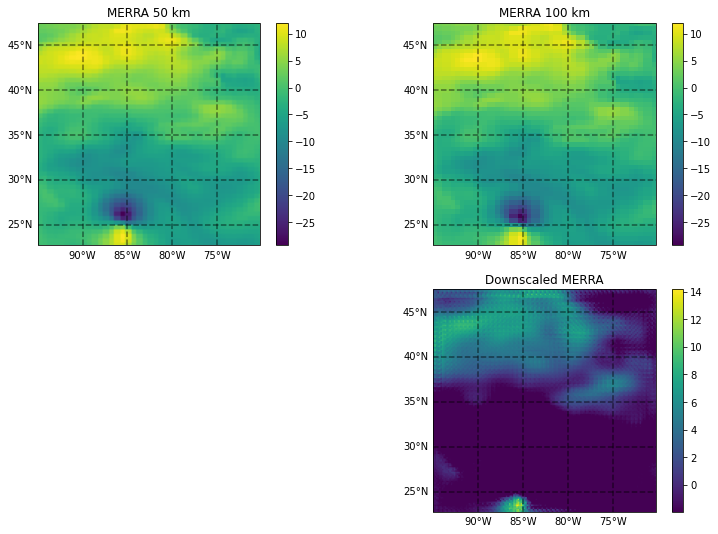

In [56]:
var_id = 3


fig, ax = plt.subplots(2, 2, figsize=(13, 9), subplot_kw={'projection': ccrs.PlateCarree()},)

out1 = ax[0, 0].imshow(merra_data[0, :,:,var_id], extent=[lon_crop.min(), lon_crop.max(), lat_crop.min(), lat_crop.max()])
#out1 = ax[0, 0].imshow(np.sqrt(merra_data[0, :,:,0]**2 + merra_data[0, :,:,1]**2) , extent=[lon_crop.min(), lon_crop.max(), lat_crop.min(), lat_crop.max()])

plt.colorbar(out1, ax=ax[0,0])

out2 = ax[0, 1].imshow(merra_downgraded_data[0, :,:,var_id], extent=[lon_crop.min(), lon_crop.max(), lat_crop.min(), lat_crop.max()])
#out2 = ax[0, 1].imshow( np.sqrt( merra_downgraded_data[0, :,:,0]**2 + merra_downgraded_data[0, :,:,0]**2 ), extent=[lon_crop.min(), lon_crop.max(), lat_crop.min(), lat_crop.max()])

plt.colorbar(out2, ax=ax[0, 1])

out3 = ax[1, 1].imshow(merra_downscale[0, :, :, var_id], extent=[lon_crop.min(), lon_crop.max(), lat_crop.min(), lat_crop.max()])
# out3 = ax[1, 1].imshow( np.sqrt( merra_downscale[0, :, :, 0]**2 + merra_downscale[0, :, :, 1]**2), extent=[lon_crop.min(), lon_crop.max(), lat_crop.min(), lat_crop.max()])

plt.colorbar(out3, ax=ax[1, 1])

# [ax.coastlines() for ax in ax.ravel()]
[coast(ax) for ax in ax.ravel()]
fig.delaxes(ax[1, 0])

ax[0,0].set_title('MERRA 50 km')
ax[0,1].set_title(f'MERRA {50*factor} km')
ax[1,1].set_title('Downscaled MERRA')

plt.show()


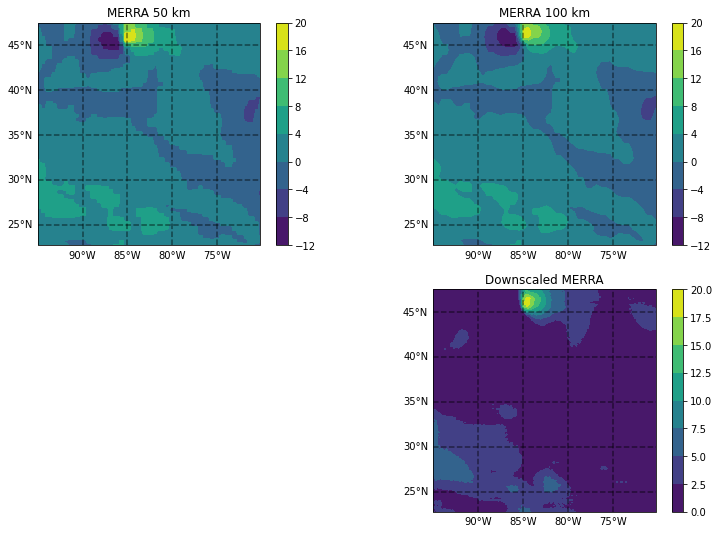

In [47]:

fig, ax = plt.subplots(2, 2, figsize=(13, 9), subplot_kw={'projection': ccrs.PlateCarree()},)

out1 = ax[0, 0].contourf(merra_data[0, :,:,var_id], extent=[lon_crop.min(), lon_crop.max(), lat_crop.min(), lat_crop.max()])
plt.colorbar(out1, ax=ax[0,0])

out2 = ax[0, 1].contourf(merra_downgraded_data[0, :,:,var_id], extent=[lon_crop.min(), lon_crop.max(), lat_crop.min(), lat_crop.max()])
plt.colorbar(out2, ax=ax[0, 1])

out3 = ax[1, 1].contourf(merra_downscale[0, :, :, var_id], extent=[lon_crop.min(), lon_crop.max(), lat_crop.min(), lat_crop.max()])
plt.colorbar(out3, ax=ax[1, 1])

# [ax.coastlines() for ax in ax.ravel()]
[coast(ax) for ax in ax.ravel()]
fig.delaxes(ax[1, 0])

ax[0,0].set_title('MERRA 50 km')
ax[0,1].set_title('MERRA 100 km')
ax[1,1].set_title('Downscaled MERRA')

plt.show()

In [ ]:
pcp_downgraded = pcp_crop[::upscale_factor, ::upscale_factor]
print(pcp_downgraded.shape)
test_out = np.stack((pcp_downgraded, pcp_downgraded, pcp_downgraded), axis=2)
print(test_out.shape)

input = np.expand_dims(test_out, axis=0)
print(input.shape)

output = model.predict(input)

print(output.shape)


In [24]:
def coast(ax):
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1.5, color='k', alpha=0.5, linestyle='--')
    gl.top_labels  = False
    gl.left_labels  = True
    gl.right_labels  = False

In [ ]:
def downscale(lon_crop, lat_crop, var):


    var_downgraded = var[::2, ::2]
    test_out = np.stack((var_downgraded, var_downgraded, var_downgraded), axis=2)

    input = np.expand_dims(test_out, axis=0)
    
    output = model.predict(input)


    fig, ax = plt.subplots(2, 2, figsize=(13, 9), subplot_kw={'projection': ccrs.PlateCarree()},)


    ax[0, 0].imshow(lowres_img_arr[:, :, 0], extent=[lon_crop.min(), lon_crop.max(), lat_crop.min(), lat_crop.max()])
    ax[0, 1].imshow(highres_img_arr[:, :, 0], extent=[lon_crop.min(), lon_crop.max(), lat_crop.min(), lat_crop.max()])
    ax[1, 1].imshow(predict_img_arr[:, :, 0], extent=[lon_crop.min(), lon_crop.max(), lat_crop.min(), lat_crop.max()])
    ax[1, 0].imshow(pcp_crop, extent=[lon_crop.min(), lon_crop.max(), lat_crop.min(), lat_crop.max()])
    ax[1, 0].set_title('TRMM 25 km')
    [ax.coastlines() for ax in ax.ravel()]

    ax[1, 1].set_title('Downscaled 10 km')
    [coast(ax) for ax in ax.ravel()]


In [ ]:
from pydap.client import open_url
from pydap.cas.urs import setup_session

#url = 'https://gpm1.gesdisc.eosdis.nasa.gov/dods/GPM_3IMERGHHL_06'
#session = setup_session(username='ankurk017', password='Jelly0311', check_url = url)
#dataset = open_url(url, session=session)

In [ ]:
import datetime

def get_trmm_file(input_date_str):
    # Convert input date to datetime object
    input_date = datetime.datetime.strptime(input_date_str, "%Y%m%d%H")

    # Calculate Julian date
    julian_date = input_date.timetuple().tm_yday

    # Generate link with Julian date
    link = f"https://disc2.gesdisc.eosdis.nasa.gov/opendap/TRMM_RT/TRMM_3B42RT.7/{input_date.year}/{julian_date}/3B42RT.{input_date.strftime('%Y%m%d%H')}.7.nc4"

    return link


In [ ]:
# NIO Cyclone
file = get_trmm_file('2018101018')
ROI = [82, 88, 14, 20]

# Hurricane Harvey
file = get_trmm_file('2017082506')
ROI = [-100, -90, 20, 30]

# Hurricane Florence
# file = get_trmm_file('2018091406')
# ROI = [-82, -72, 30, 40]


session = setup_session('ankurk017', passcode, check_url=file)
dataset = open_url(file, session=session)

lon = dataset['lon'].data[:]
lat = dataset['lat'].data[:]

lon_id = np.where(np.logical_and(lon>ROI[0], lon<ROI[1]))[0]
lat_id = np.where(np.logical_and(lat>ROI[2], lat<ROI[3]))[0]

pcp = dataset['precipitation'].data[:]

lon_crop = lon[lon_id][:-1]
lat_crop = lat[lat_id][:-1]
pcp_crop = dataset['precipitation'].data[slice(lat_id[0],lat_id[-1]), slice(lon_id[0],lon_id[-1])]



In [ ]:
model.predict(np.random.random((1,  10, 10, 3))).shape

In [ ]:
pcp_crop.shape
pcp_downgraded = pcp_crop[::upscale_factor, ::upscale_factor]
print(pcp_downgraded.shape)
test_out = np.stack((pcp_downgraded, pcp_downgraded, pcp_downgraded), axis=2)
print(test_out.shape)

input = np.expand_dims(test_out, axis=0)
print(input.shape)
output = model.predict(input)

print(output.shape)



In [ ]:

fig, ax = plt.subplots(2, 2, figsize=(13, 9), subplot_kw={'projection': ccrs.PlateCarree()},)

ax[0, 0].imshow(pcp_crop, extent=[lon_crop.min(), lon_crop.max(), lat_crop.min(), lat_crop.max()])
ax[0, 1].imshow(pcp_downgraded, extent=[lon_crop.min(), lon_crop.max(), lat_crop.min(), lat_crop.max()])
ax[1, 1].imshow(output.squeeze()[:, :, 0], extent=[lon_crop.min(), lon_crop.max(), lat_crop.min(), lat_crop.max()])

# [ax.coastlines() for ax in ax.ravel()]
[coast(ax) for ax in ax.ravel()]
plt.show()

In [ ]:
plt.imshow(pcp_crop)
plt.colorbar()

In [ ]:
plt.imshow(pcp_downgraded)
plt.colorbar()

In [ ]:
plt.imshow(output.squeeze()[:, :, 0])
plt.colorbar()

In [ ]:
test_out = np.stack((pcp_downgraded, pcp_downgraded, pcp_downgraded), axis=2)


upscale_factor = 2

img = array_to_img(test_out)

lowres_input = get_lowres_image(img, upscale_factor)

w = lowres_input.size[0] * upscale_factor
h = lowres_input.size[1] * upscale_factor

highres_img = img.resize((w, h))

prediction = upscale_image(model, lowres_input)

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(13, 5))
ax[0].imshow(pcp_crop)
ax[1].imshow(pcp_downgraded)
ax[2].imshow(img_to_array(prediction)[:,:,0])
ax[0].set_title('TRMM')
ax[1].set_title('TRMM downgraded')
ax[2].set_title('TRMM upgraded')

In [ ]:
plt.imshow(pcp_downgraded)

In [ ]:
plt.imshow(img_to_array(prediction)[:,:,0])